In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from tqdm import tqdm

In this project, N is the number of time steps, M is the number of of path generated for the Brownian motion. For example, you could take N = 100 and M = 10, 000.

## (1) Brownian motion and Black Scholes model

#### (1.1) Brownian motion

(1.1.1) By using the rescaled random walk, build a program which give a path of a Brownian motion on [0, 1] with a time subdivision t_i = $\frac{i}{N}$ , 0 $\leq$ i $\leq$ N 

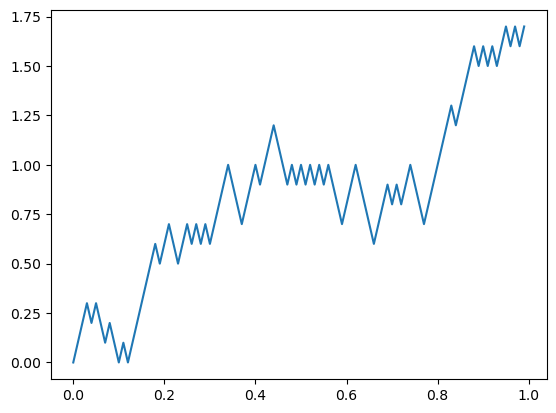

In [2]:
N = 100
np.random.seed(54321)

def walk(N):
    walks = np.random.rand(N)>0.5
    W = np.zeros(N+1)
    for i in range(len(walks)):
        # +1 if the value is > 0.5 else -1
        if walks[i]: W[i+1] = W[i] + 1
        else: W[i+1] = W[i] - 1
    # scale the term
    W = W/np.sqrt(N)
    x_axis = np.arange(0, 1, 1/N)
    np.append(x_axis, 1)
    return x_axis, W

x_axis, W = walk(N)
plt.plot(x_axis, W[:-1])

(1.1.2) Generate M path of a Brownian motion, prove numerically that E[$W_t$] = 0 and Var($W_t$) = t for different values of t.

In [3]:
N = 100
M = 10000
np.random.seed(54321)

walks = []
for i in range(M):
    # generate simple random walk
    _, cur_W = walk(N)
    walks.append(cur_W[:-1])

walks = np.array(walks)

In [4]:
# value of E[Wt] at random indices
np.mean(walks[:, [i for i in range(0, N, 13)]], axis=0)

# we can see that the mean at random indices are close to 0.

array([ 0.     , -0.00288, -0.00332,  0.00092,  0.00146, -0.0007 ,
        0.00318,  0.00126])

In [5]:
# absolute difference between var(Wt) and t at random indices

np.abs(np.var(walks[:, [i for i in range(10)]], axis=0) \
    - np.arange(0, 1, 1/N)[:10])

# again, we show that the variance at random indices i is very close to i itself.

array([0.000000e+00, 2.916000e-07, 3.501504e-04, 1.142500e-04,
       7.078400e-06, 5.602916e-04, 7.138496e-04, 1.759600e-04,
       1.057424e-04, 9.961584e-04])

(1.1.3) Compute numerically $[W, W]_t$ and observe that $[W, W]_t$ = t for some value of t.

In [14]:
ts = np.arange(0.1, 1.1, 0.2) # choose t as some random value between 0 and 1
qvs_mean, qvs_std = [], []
for t in ts:
    steps = int(t * N)
    # limit the walks range for each t and calculate the mean/variance
    qvs_mean.append(np.mean(np.sum(np.diff(walks[:, :steps+1])**2, axis=1)))
    qvs_std.append(round(np.std(np.sum(np.diff(walks[:, :steps+1])**2, axis=1)), 5))

print(f"qvs_mean: {qvs_mean}\nqvs_std: {qvs_std}\ntimestamp: {ts}\n")
print("The result shows that the quadratic variation at time t will just be t, \nand the variance of the quadratic variation is very close to 0.")

qvs_mean: [0.10000000000000003, 0.30000000000000004, 0.5, 0.7, 0.9000000000000004]
qvs_std: [0.0, 0.0, 0.0, 0.0, 0.0]
timestamp: [0.1 0.3 0.5 0.7 0.9]

The result shows that the quadratic variation at time t will just be t, 
and the variance of the quadratic variation is very close to 0.


#### (1.2) Stochastic integral

In this section we are studying

$$
    I = \int_0^1W_sdW_s
$$

We propose two schemes to approach numerically I on each path w $\in \Omega$:

$$
    I^-(w) = \sum_{i = 0}^NW_{t_{i+1}}(w)(W_{t{i+1}}(w) - W_{t_{i}}(w))
$$

or 

$$
    I_-(w) = \sum_{i = 0}^NW_{t_{i}}(w)(W_{t_{i+1}}(w) - W_{t_{i}}(w))
$$

(1.2.1) Observe numerically that $I^-=\frac{1}{2}W_1^2 + \frac{1}{2}$ almost surely

In [7]:
I_upper = np.mean(np.sum((np.diff(walks) * walks[:, 1:]), axis=1))
theoretical_val = 0.5 * np.mean(walks[:, -1]**2) + 0.5

I_upper, theoretical_val

(0.983876, 0.9888759999999999)

(1.2.2) Observe numerically that $I_-=\frac{1}{2}W_1^2 - \frac{1}{2}$ almost surely

In [8]:
I_lower = np.mean(np.sum((np.diff(walks) * walks[:, :-1]), axis=1))
theoretical_val = 0.5 * np.mean(walks[:, -1]**2) - 0.5

I_lower, theoretical_val

(-0.006123999999999932, -0.011124000000000078)

(1.2.3) Which definition of I do we keep in view of Ito’s formula applied to $W^2_1$?

- When applying Ito's formula to $W_1^2$, we aim to oderive the stoachastic integral of $W_tdW_t.$ The Ito's decomposition of $f(W_t)=W_t^2$ is $$df(W_t)=2W_tdW_t+dt.$$ Integrating both sides from 0 to 1 gives $$\int_0^12W_tdW_t+\int_0^1dt=W^2_1-W^2_0$$ Since $W_0=0,$ we have $$ \int_0^1W_tdW_t=\frac{1}{2}W^2_1-\frac{1}{2}$$ which corresponds to $I_-(w)=\sum_{i = 0}^NW_{t_{i}}(w)(W_{t_{i+1}}(w) - W_{t_{i}}(w))$ if we turn the integral into discrete summation. Hence $I_-$ is the choice we take.

(1.2.4) Compute numerically $E[I]$ and $E[I^2]$ for the choice of I made in question 3. and compare with the theoretical values.

In [16]:
# the theoretical expectation is 0 and variance is 1/2.
simulated_expectation = 0.5 * np.mean(walks[:, -1]**2) - 0.5
simulated_variance = 0.25 * np.std(walks[:, -1]**2)**2 + simulated_expectation**2

print({"simulated expectation": simulated_expectation,"true expectation": 0})
print({"simulated variance": simulated_variance, "true variance": 0.5})

print("We see that the expected expectation by simulation are very similar to\nthe true expectation, while the expected variance by simulation is very close to the true variance.")

{'simulated expectation': -0.011124000000000078, 'true expectation': 0}
{'simulated variance': 0.46426152, 'true variance': 0.5}
We see that the expected expectation by simulation are very similar to
the true expectation, while the expected variance by simulation is very close to the true variance.


#### (1.3) Black-Scholes model

(1.3.1) Solution to SDE

The Black-Scholes price is solution to the following SDE under the risk neutral probability measure:
$$
dS_t = S_trdt + S_t\sigma dW_t, S_0 > 0, r \ge 0, \sigma > 0.
$$
We denote by S the solution to such equation. 
- By using the discretization of the time $t_i = \frac{i}{N}$ with $0 \leq i \leq N$, we introduce the following Euler-Maruyama numerical scheme: $$\tilde{S}_0=S_0 \\ \tilde{S}_{t_{i+1}} − \tilde{S}_{t_{i}} =  \tilde{S}_{t_{i}} r(t_{i+1} − t_i) + \tilde{S}_{t_{i}} \sigma (W_{t_{i+1}} − W_{t_i}) $$ Compare $\tilde{S}_{t_{i}}$ and $S_0e^{\sigma W_t+(r−\sigma^2/2)t}$ for some values of $t \in [0, 1]$.

In [17]:
# setup
S0 = 100
r = 0.05
sig = 0.1
N = 100
M = 10000
cur_walk = walks[99]

# generate S tilde
S_tilde = [S0]
for i in range(1, N):
    cur_S_tilde = S_tilde[i-1] + S_tilde[i-1] * r * (1/N) + S_tilde[i-1] * sig * (cur_walk[i] - cur_walk[i-1])
    S_tilde.append(cur_S_tilde)

test_idx = 50 # between 0 and 100
S_tilde[test_idx], S0 * np.exp(sig * cur_walk[test_idx] + (test_idx / N) * (r-sig**2)/2)

(104.34022793610154, 103.0454533953517)

- Compute numerically $E[S_1]$ by approaching the expectation with the Monte Carlo method, that is $E[S_1] \approx \frac{1}{M}\sum_{j=1}^MS^{(j)}_1$ where $S^{(j)}_1$ is the $jth$ simulation generated by you algorithm of $S_t$.

In [18]:
# Repeat previous part for M times
Ss = []
for j in range(M):
    S_tilde = [S0]
    cur_walk = walks[j]
    for i in range(1, N):
        cur_S_tilde = S_tilde[i-1] + S_tilde[i-1] * r * (1/N) + \
                      S_tilde[i-1] * sig * (cur_walk[i] - cur_walk[i-1])
        S_tilde.append(cur_S_tilde)
    
    Ss.append(S_tilde[-1])

monte_carlo_price = np.mean(Ss)
monte_carlo_price


105.0990753436162

(1.3.2) Black-Scholes price of European call and put option

- Create a function CallBS (resp. PutBS) with input $r, \sigma, S_0, T, K$ which returns the Black-Scholes price of a European call (resp. put) option.

In [19]:
def CallBS(S0:float=100, K:float=100, r:float=0.1, sigma:float=0.1, 
        T:float=1, call:bool=True) -> float:
    '''
    Implementation of black shore. Served as the true value of the option.
    @param s0: spot price for the stock
    @param k: strike price
    @param r: risk free rate
    @param sigma: volatility
    @param T: time span
    @param call: if a call or put option
    
    @return out: value of the option 
    '''
    d1 = (np.log(S0/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    
    if call:
        out = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        out = K * np.exp(-r*T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return out

- Fix the initial price $S_0 = 40$ and $T = 1$. Observe that the price at time 0 of a call option is convex with respect to the strike.

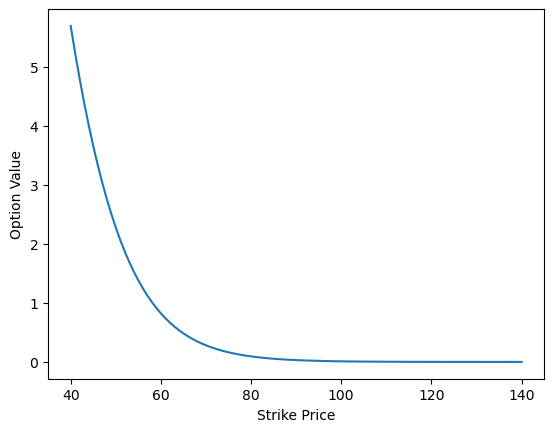

In [32]:
S0 = 40
r = 0.05
sigma = 0.3
T = 1
prices = []

for k in range(S0, 141):
    # iterate through value of K from 40 to 141
    init_price_cur = CallBS(S0=S0, K=k, r=r, sigma=sigma, T=T)
    prices.append(init_price_cur)

plt.plot(range(S0, 141), prices)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.show()

- Verify numerically the call-put parity for different values of the inputs.

In [21]:
S0 = 50
r = 0.1
sigma = 0.3
T = 1
K = 55

# we want to verify that put-call parity holds
callopt = CallBS(S0=S0, K=K, r=r, sigma=sigma, T=T, call=True)
putopt = CallBS(S0=S0, K=K, r=r, sigma=sigma, T=T, call=False)

LHS = callopt - putopt
RHS = S0 - K*math.e**(-r)

LHS, RHS

(0.23394200802222542, 0.23394200802222542)

#### (1.4) Approximation formula

We recall that the ATM call option is such that $K^{ATM} = e^{rT} S_0.$

(1.4.1) We recall that for $\sigma \sqrt{T}$ small enough, $CallBS(r, \sigma, S_0, T, K^{ATM}) \approx 0.4S_0\sigma \sqrt{T}.$ Check this property numerically by fixing $T=1$ and $\sigma$ varying in a small interval.

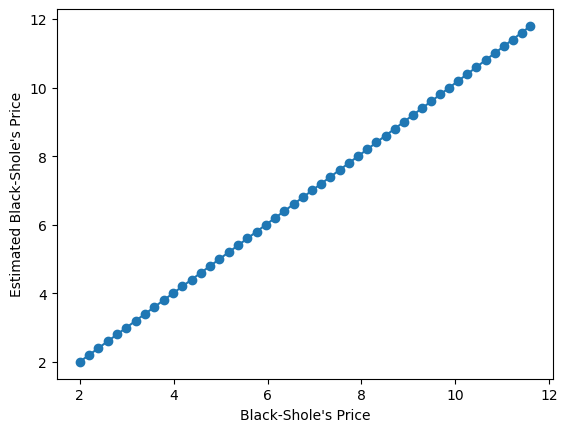

In [37]:
S0 = 50
r = 0.1
T = 1
K = np.exp(r*T)*S0
lhs = []
rhs = []

for sigma in range(10, 60):
    sigma = sigma/100
    lhs.append(CallBS(S0=S0, K=K, r=r, sigma=sigma, T=T, call=True))
    rhs.append(0.4 * S0 * sigma * np.sqrt(T))

plt.scatter(np.array(lhs), np.array(rhs))
plt.plot(np.array(lhs), np.array(rhs))
plt.xlabel("Black-Shole's Price")
plt.ylabel("Estimated Black-Shole's Price")
plt.show()

(1.4.2) The Delta of a call option at the money is given by 
$$
    \Delta_0 = N(d_+),
$$
with $$d_+ = \frac{\sigma}{2}\sqrt{T}.$$ We recall that for $\sigma\sqrt{T}$ small enough, $\Delta \approx 0.5 + 0.2\sigma\sqrt{T}.$ Check this property numerically by fixing $T = 1$ and $\sigma$ varying in a small interval.

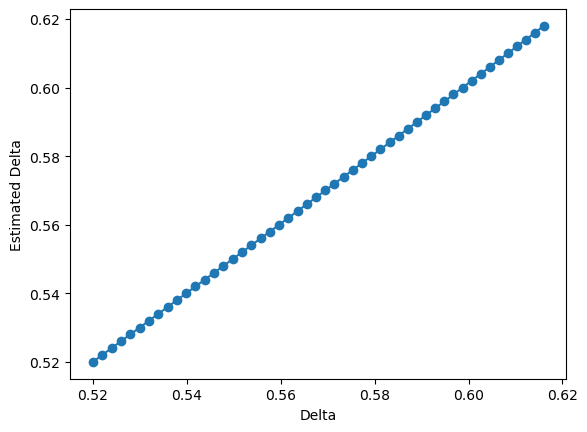

In [38]:
S0 = 50
r = 0.1
T = 1
K = np.exp(r*T)*S0
lhs = []
rhs = []

for sigma in range(10, 60):
    sigma = sigma/100
    d1 = sigma * np.sqrt(T)/2
    delta_cur = norm.cdf(d1)
    lhs.append(delta_cur)
    rhs.append(0.5 + 0.2 * sigma * np.sqrt(T))

plt.scatter(np.array(lhs), np.array(rhs))
plt.plot(np.array(lhs), np.array(rhs))
plt.xlabel("Delta")
plt.ylabel("Estimated Delta")
plt.show()

(1.4.3) The Vega of a call option at time 0 at the money is given by $$V = S_0N'(d_+)\sqrt{T}.$$ We recall that for $\sigma\sqrt{T}$ small enough, $V \approx 0.4S_0\sqrt{T}.$ Check this property numerically by fixing T = 1 and σ varying in a small interval.

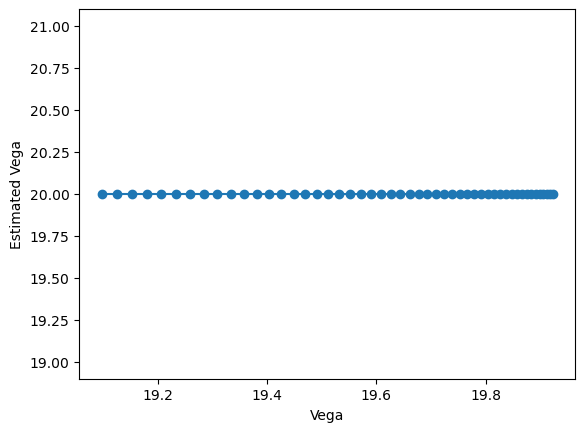

In [39]:
S0 = 50
r = 0.1
T = 1
K = np.exp(r*T)*S0
lhs = []
rhs = []

for sigma in range(10, 60):
    sigma = sigma/100
    d1 = sigma * np.sqrt(T)/2
    vega_cur = S0 * norm.pdf(d1) * np.sqrt(T)
    lhs.append(vega_cur)
    rhs.append(0.4 * S0 * np.sqrt(T))

plt.scatter(np.array(lhs), np.array(rhs))
plt.plot(np.array(lhs), np.array(rhs))
plt.xlabel("Vega")
plt.ylabel("Estimated Vega")
plt.show()

## (2) Black-Scholes v.s. Bachelier

We assume that r = 0. In the Bachelier model, we suppose that the price of this asset is
$$
S_t^{(B)} = S_0 + \sigma^{(B)}W_t, \ S_0>0, \  \sigma^{(B)} > 0
$$
The Bachelier price of a call option is given by
$$
CallBach(0, \sigma^{(B)}, S_0, T, K) = E[(S_T^{(B)}-K)^+]=(S_0-K)N(\frac{S_0-K}{\sigma^{(B)}\sqrt{T}})+ \sigma^{(B)}\phi(\frac{S_0-K}{\sigma^{(B)}\sqrt{T}}),
$$
where $N$ is the c.d.f of the standard normal law and $\phi(x)=\frac{e^{-x^2}}{\sqrt{2\pi}}.$

#### (2.1.1) Create a function CallBach with input $\sigma^{(B)}, S_0, T, K$ which returns the Bachelier price of a European call option.

In [41]:
def CallBach(sig:float=0.3, s0:float=100, t:float=1, k:float=100):
    '''
    Implementation of bachelier model. Return the value of the option.
    @param sig: volatility
    @param s0: spot price for the stock
    @param t: time span
    @param k: strike price 
    
    @return out: value of the option 
    '''
    # compute d as per the Bachelier model
    d = (s0 - k) / (sig * np.sqrt(t))

    # calculate cdf and pdf of d
    N_d = norm.cdf(d)
    phi_d = norm.pdf(d)

    out = (s0 - k) * N_d + sig * np.sqrt(T) * phi_d

    return out

In [42]:
CallBach()

0.1196826841204298

#### (2.1.2) Verify numerically that at the money (that is S0 = K) we have $$0\leq Callbach(0, \sigma^{(B)}, S_0, T, S_0) - CallBS(0, \sigma^{(BS)}, S_0, T, S_0)\\ \leq \frac{S_0}{24\sqrt{2\pi}}|\sigma^{(BS)}|^3T^{3/2},$$ where $\sigma^{(B)}=S_0\sigma^{(BS)}$

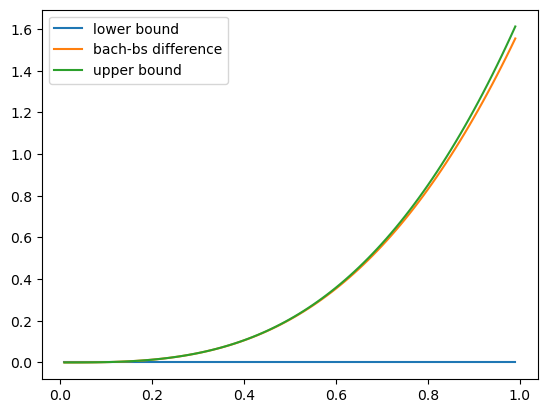

In [48]:
lhss = []
mhss = []
rhss = []
for sig_bs in range(1, 100):
    sig_bs = sig_bs / 100
    s0 = 100
    sig_ba = s0 * sig_bs
    t = 1

    lhss.append(0)
    mhss.append(CallBach(sig_ba, s0, t, s0) - CallBS(s0, s0, 0, sig_bs, t))
    rhss.append((s0/(24*np.sqrt(2*math.pi))) * (abs(sig_bs)**3) * t**(3/2))

    # print(f"{lhs} < {mhs} < {rhs} for sigma of black sholes = {sig_bs}")

plt.plot([x/100 for x in range(1, 100)], lhss, label="lower bound")
plt.plot([x/100 for x in range(1, 100)], mhss, label="bach-bs difference")
plt.plot([x/100 for x in range(1, 100)], rhss, label="upper bound")
plt.legend()
plt.show()

## (3) Pricing Asian option in the Black-Scholes model

This part is based on 
- Kemna, A. G., & Vorst, A. C. (1990). A pricing method for options based on average
asset values. Journal of Banking & Finance, 14(1), 113-129.

The goal is to find the price of an Asian option, with payoff at time T is given by $(A_T-K)^+$ where $A_T=\frac{1}{T}\int_0^TS_tdt.$ This is an option on the mean of the asset S. 

This part follows Section 3: special characteristics of the AV-options and Section 4. Numerical Computations in the article of Nemna and Vorst. 

To do so, we use Monte-Carlo methods and we approach the integral as follow
$$
(Arithmetic mean) A_T \approx A_T^a := \frac{1}{n+1}\sum_{i=0}^nS_{t_i}, t_i = i\frac{T}{n}, \\
(Geometric mean) A_T \approx A_T^g := (\Pi_{i=0}^nS_{t_i})^{\frac{1}{n+1}}, t_i=i\frac{T}{n}.
$$
The price at time 0 of the Average-Value option is
$$
CallAsian(r, \sigma, S_0, T, K) = e^{-rT}E[(A_T-K)^+],
$$
depending on the approximation of A chosen.

#### (3.1) Compute the price of the Asian option CallAsian by approaching the expectation $E[(A_T − K)^+]$ with Monte Carlo method for different values of the parameters for both the arithmetical mean and the geometric mean

In [49]:
N = 100
M = 10000

def GBM(s0, r, sigma, T):
    """
    Simuilation of stock price
    @param s0: spot price for the stock
    @param r: rate
    @param sigma: volatility
    @param T: time span
    
    @return out: stock prices 
    """
    np.random.seed(54321)
    
    out = []
    dt = T/N
    for _ in range(M):
        cur_prices = [s0]
        W = np.random.standard_normal(size = (N-1))
        for n in range(1, N):
            next_price = cur_prices[n-1] * np.exp((r-0.5*(sigma**2)\
                            )*dt + sigma*np.sqrt(dt)*(W[n-1]))
            cur_prices.append(next_price)
        out.append(cur_prices)
    
    return np.array(out)

In [57]:
T = 1
K = 110
s0s = []
rs = []
sigmas = []
gbm_lists = []
arith_means = []
geom_means = []

for s0 in [90, 100]:
    for r in [0.03, 0.05]:
        for sigma in [0.2, 0.3]:
            s0s.append(s0)
            rs.append(r)
            sigmas.append(sigma)

            gbm_prices = GBM(s0, r, sigma, T)
            gbm_lists.append(gbm_prices)

            # arithmetical mean
            arith_mean = np.mean(np.maximum(np.mean(gbm_prices,axis=1) - K, 0))
            arith_means.append(arith_mean)

            # geometric mean
            geom_mean = np.mean(np.maximum(np.prod(gbm_prices,axis=1)**(1/gbm_prices.shape[1]) \
                                           - K, 0))
            geom_means.append(geom_mean)

            # cur_str = f"s0: {s0}, r: {r}, sigma: {sigma} | arithmetic mean: {arith_mean} | geometric mean: {geom_mean}"
            # print(cur_str)

d = {"S0": s0s, "Rate": rs, "Sigma": sigmas, "Arith_Mean": arith_means, "Geom_Mean": geom_means}
table = pd.DataFrame(data=d)
out_table = table.copy()
out_table["Diff_Proportion"] = np.abs(out_table.Arith_Mean-out_table.Geom_Mean)/out_table.Geom_Mean
print("The table shows the price of Asian option with different parameters\nfor arithmetical and geometric mean. It also shows by how much they differ with different parameters.")
out_table


The table shows the price of Asian option with different parameters
for arithmetical and geometric mean. It also shows by how much they differ with different parameters.


,S0,Rate,Sigma,Arith_Mean,Geom_Mean,Diff_Proportion
0,90,0.03,0.2,0.264600,0.220601,0.199449
1,90,0.03,0.3,1.279523,1.092371,0.171326
2,90,0.05,0.2,0.329383,0.275125,0.197215
3,90,0.05,0.3,1.446532,1.234943,0.171335
4,100,0.03,0.2,1.770048,1.639631,0.079540
5,100,0.03,0.3,3.853558,3.523158,0.093780
6,100,0.05,0.2,2.060647,1.908820,0.079539
7,100,0.05,0.3,4.239824,3.874205,0.094373


#### (3.2) Provide the confidence interval at 95% in each case and observe that the interval is reduced when we choose the geometric mean

In [59]:
T = 1
K = 110
i = 0
arith_confs = []
geom_confs = []

for s0 in [90, 100]:
    for r in [0.03, 0.05]:
        for sigma in [0.2, 0.3]:
                cur_gbm = gbm_lists[i]

                # arithematic confidence interval
                arith_lists = np.maximum(np.mean(cur_gbm,axis=1) - K, 0)
                arith_mean = np.mean(arith_lists)
                arith_merr = 1.96 * np.std(arith_lists) / np.sqrt(len(arith_lists))
                arith_conf = [round(arith_mean-arith_merr, 3), round(arith_mean+arith_merr, 3)]
                arith_confs.append(arith_conf)

                # geometric confidence interval
                geom_lists = np.maximum(np.prod(cur_gbm,axis=1)**(\
                        1/cur_gbm.shape[1]) - K, 0)
                geom_mean = np.mean(geom_lists)
                geom_merr = 1.96 * np.std(geom_lists) / np.sqrt(len(geom_lists))
                geom_conf = [round(geom_mean-geom_merr, 3), round(geom_mean+geom_merr, 3)]
                geom_confs.append(geom_conf)

                # cur_str = f"s0: {s0}, r: {r}, sigma: {sigma} | arith_conf: {arith_confs} | geom_conf: {geom_confs}"
                # print(cur_str)

                i += 1

out_table = table.copy()
out_table["Arith_Conf"] = arith_confs
out_table["Geom_Conf"] = geom_confs
cols = ["S0", "Rate", "Sigma", "Arith_Conf", "Arith_Mean", "Geom_Conf", "Geom_Mean"]
out_table = out_table[cols]
print("We observe that geometric interval is reduced and each value is within its\ncorresponding confidence interval.")
out_table

We observe that geometric interval is reduced and each value is within its
corresponding confidence interval.


,S0,Rate,Sigma,Arith_Conf,Arith_Mean,Geom_Conf,Geom_Mean
0,90,0.03,0.2,"[0.233, 0.297]",0.264600,"[0.192, 0.249]",0.220601
1,90,0.03,0.3,"[1.185, 1.374]",1.279523,"[1.009, 1.176]",1.092371
2,90,0.05,0.2,"[0.293, 0.366]",0.329383,"[0.243, 0.307]",0.275125
3,90,0.05,0.3,"[1.346, 1.547]",1.446532,"[1.146, 1.324]",1.234943
4,100,0.03,0.2,"[1.68, 1.86]",1.770048,"[1.555, 1.724]",1.639631
5,100,0.03,0.3,"[3.683, 4.025]",3.853558,"[3.365, 3.681]",3.523158
6,100,0.05,0.2,"[1.963, 2.158]",2.060647,"[1.817, 2.001]",1.908820
7,100,0.05,0.3,"[4.06, 4.42]",4.239824,"[3.708, 4.041]",3.874205


#### (3.3) Compare the results with the price at time 0 of a European call option CallBS

In [61]:
T = 1
K = 110
i = 0
bs_prices = []

for s0 in [90, 100]:
    for r in [0.03, 0.05]:
        for sigma in [0.2, 0.3]:

            arith_mean = arith_means[i]
            geom_mean = geom_means[i]

            # european CallBS
            bs_price = CallBS(S0=s0, K=K, r=r, sigma=sigma, T=T)
            bs_prices.append(bs_price)
            
            # cur_str = f"s0: {s0}, r: {r}, sigma: {sigma} | arithmetic mean: {round(arith_mean, 3)} | geometric mean: {round(geom_mean, 3)} | bs price: {round(bs_price, 3)}"
            # print(cur_str)
            i += 1

out_table = table.copy()
out_table["BS_Price"] = bs_prices
print("We observe that European call option price under BS-model is much higher\nthan Asian call option pricem, under different parameter settings.\nThis is partially because European options priced under the Black-Scholes\nmodel depend only on the terminal stock price and not on the path or the\naverage price during the life of the option")
out_table

We observe that European call option price under BS-model is much higher
than Asian call option pricem, under different parameter settings.
This is partially because European options priced under the Black-Scholes
model depend only on the terminal stock price and not on the path or the
average price during the life of the option


,S0,Rate,Sigma,Arith_Mean,Geom_Mean,BS_Price
0,90,0.03,0.2,0.264600,0.220601,2.136420
1,90,0.03,0.3,1.279523,1.092371,5.184438
2,90,0.05,0.2,0.329383,0.275125,2.523716
3,90,0.05,0.3,1.446532,1.234943,5.705478
4,100,0.03,0.2,1.770048,1.639631,5.293398
5,100,0.03,0.3,3.853558,3.523158,9.240027
6,100,0.05,0.2,2.060647,1.908820,6.040088
7,100,0.05,0.3,4.239824,3.874205,10.020078


## (4) Pricing zero-coupon bond in the Vasicek model

The Vasicek Model is used to model interest rates and it has the following SDE representation
$$
dr_t = a(b-r_t)dt + \sigma dW_t, \ r_0\in \mathbb{R}
$$
A discretization of this process on [0, T ] is given by
$$
r_{t_{i+1}} = r_{t_{i}} + a(b-r_{t_{i}})(t_{t_{i+1}}-t_{t_{i}}) + \sigma(W_{t_{i+1}} - W_{t_{i}}), \ r_0\in \mathbb{R}
$$

#### (4.1) Starting from $r_0 = 0.05,$ create a function that generates M paths of the interest rate following the Vasicek model. The function takes as input the volatility, $b$ and $a$, and default inputs are ($a=1, b=0.06, \sigma = 0.3$). Playing with values of a and b, what do they represent?

In [76]:
def time_walk(N, T, M):
    # we know that every increment is N(0, t_i - t_{i-1}), so we generate white noise and
    # rescale it properly, then we cumsum on the first dimensione to get a path
    np.random.seed(12345)
    jump = T/N
    increments = np.sqrt(jump)*np.random.normal(size=(N, M))
    W = np.cumsum(increments, axis=0)
    # We stack W with n_paths 0 at the beginning since we know W_0 = 0
    W = np.vstack((np.zeros((1, M)), W))
    return W


def generate_vasicek(r0:float, a:float, b:float, sigma:float, T:float, N:int, M:int):
    """
    Simuilation of interest rate under Vasicek model
    @param r0: initial interest rate
    @param a: parameter 1
    @param b: parameter 2
    @param sigma: volatility
    @param M: number of rates generated
    
    @return out: interest rates 
    """
    rate_paths = np.zeros((M, N+1))
    dt = T/N
    W = time_walk(N, T, M).T
    for i in range(M):
        W_increments = np.diff(W[i])
        rates = np.zeros(N+1)
        rates[0] = r0
        for j in range(1, N+1):
            rates[j] = rates[j-1] + a * (b - rates[j-1]) * dt + sigma * W_increments[j-1]
        rate_paths[i] = rates
    return rate_paths

In [79]:
r0 = 0.05
sigma = 0.3
T = 1
compares = dict()

for b in [0.03, 0.06, 0.1]:
    a_vals = []
    for a in tqdm(range(90, 150)):
        a = a/100
        cur_rates = generate_vasicek(r0, a, b, sigma, T, N, M)
        a_vals.append(np.mean(cur_rates, axis=0)[-1])
    compares[f"{b}"] = a_vals

100%|██████████| 60/60 [01:16<00:00,  1.28s/it]


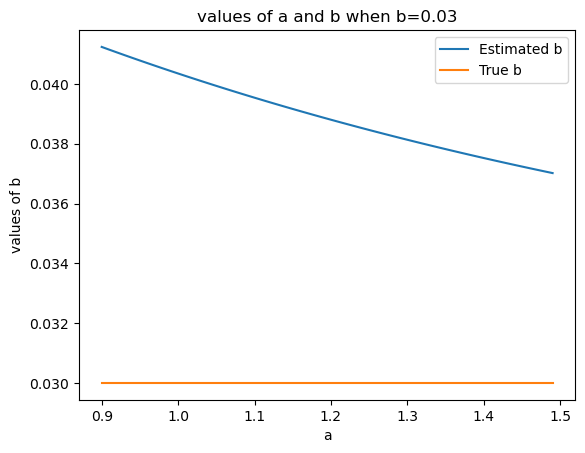

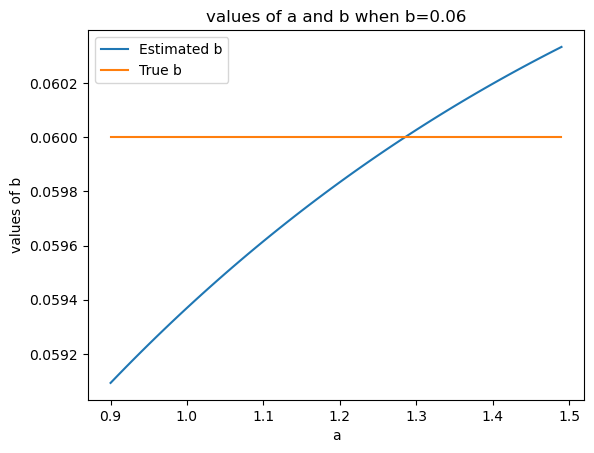

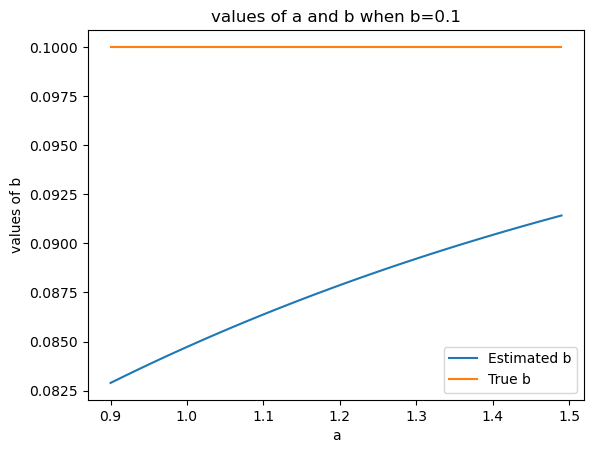

In [86]:
for b in [0.03, 0.06, 0.1]:
    plt.plot([x/100 for x in range(90, 150)], compares[f"{b}"], label="Estimated b")
    plt.plot([x/100 for x in range(90, 150)], [b]*60, label="True b")
    plt.xlabel("a")
    plt.ylabel("values of b")
    plt.legend()
    plt.title(f"values of a and b when b={b}")
    plt.show()

# """ 
#     Generally we see that when a is bigger, the average rate will be closer
#     to the corresponding b, and vice versa.

#     For parameter b, it represents the long-term mean or equilibrium level to which 
#     the interest rates are expected to revert. The parameter b is the theoretical 
#     mean that the interest rate process aims to stabilize around over a long period.

#     Parameter a quantifies the speed at which the interest rates revert to their mean level b. 
#     This is a measure of how quickly the rate corrects itself towards the equilibrium after 
#     a deviation.
# """


#### (4.2) Use the function you just created to price a Zero Coupon Bond with maturity of 0.5, 1, 2, 5 years under the Vasicek model. We recall that the price of a zero coupon bond is given by $$B_{0,T}=\mathbb{E}[e^{-\int_0^Tr_sds}]$$ You can approach the expectation with the Appendix and the integral $\int_0^Tr_sds \approx \sum r_{t_i}(t_{i+1}-t_i)$

In [28]:
r0 = 0.05
a = 1
b = 0.06
sigma = 0.3
i = 0
coupon_prices = []

for T in [0.5, 1, 2, 5]:
    rs = generate_vasicek(r0, a, b, sigma, T, N, M)
    coupon_price = np.mean(np.e**(-(np.sum(rs,axis=1) * (T/N))))
    coupon_prices.append(coupon_price)
    i += 1

i = 0
for T in [0.5, 1, 2, 5]:
    print(f"T: {T} | simulated coupon price: {coupon_prices[i]}")
    i += 1

# Codes above will simulate the Vasicek model for interest rates 
# over different maturities and compute the price of zero-coupon bonds 
# for those maturities. By comparing the bond prices for different 
# maturities, we can see the price is higher for less time to mature

T: 0.5 | simulated coupon price: 0.9747558188647041
T: 1 | simulated coupon price: 0.9532658640603892
T: 2 | simulated coupon price: 0.9229228594694953
T: 5 | simulated coupon price: 0.8722551737875823


#### (4.3) Compare your result with the explicit formula $$B_0(T)=\exp\bigg[-bT+(b-r_0)\frac{1-e^{-aT}}{a}-\frac{\sigma^2}{4a^3}(1-e^{-aT})^2+\frac{\sigma^2}{2a^2}(T-\frac{1-e^{-aT}}{a})\bigg]$$

In [29]:
r0 = 0.05
a = 1
b = 0.06
sigma = 0.3
i = 0
explicity_coupon_prices = []

for T in [0.5, 1, 2, 5]:
    coef = (1-np.e**(-a*T))/a
    b0 = np.e**(-b*T + (b-r0)*coef - ((sigma**2)/(4*a))*(coef**2) + \
                ((sigma**2)/(2*a**2)) * (T-coef))
    explicity_coupon_prices.append(b0)

for T in [0.5, 1, 2, 5]:
    print(f"T: {T} | simulated coupon price: {coupon_prices[i]} | explicity coupon prices: {explicity_coupon_prices[i]}")
    i += 1


# """
#     For shorter maturities (0.5 and 1 year), the prices from both 
#     methods are very close. This indicates that both the explicit 
#     formula and the Monte Carlo simulation yield similar valuations 
#     when the maturity is relatively near-term.

#     For longer maturities, particularly at T=5 years, the discrepancy 
#     between the two methods becomes quite significant. The explicit 
#     formula gives a bond price of 0.8764, whereas the Monte Carlo 
#     simulation results in a considerably lower price of 0.7718. This 
#     could be due to the fact that the approximation of the integral 
#     is less accurate.
# """

T: 0.5 | simulated coupon price: 0.9747558188647041 | explicity coupon prices: 0.9755490535383189
T: 1 | simulated coupon price: 0.9532658640603892 | explicity coupon prices: 0.9549324360659
T: 2 | simulated coupon price: 0.9229228594694953 | explicity coupon prices: 0.925810897812307
T: 5 | simulated coupon price: 0.8722551737875823 | explicity coupon prices: 0.8763743091683309
